# Power Trading Dashboard: Model Training and Strategy Development
***
### Project Overview
This notebook documents the development and training of a forecasting model for a Power Trading Dashboard. The primary objectives are:

- Modeling Power Prices: Predicting future electricity prices using weather data and seasonal patterns.
- Generating Trading Strategies: Identifying optimal trading actions by analyzing predicted price spreads.

### Trading Strategy Logic
- Short the Spread: When the market overvalues the spread (market prices exceed model predictions).
- Long the Spread: When the market undervalues the spread (market prices fall below model predictions).


In [573]:
import pandas as pd
import datetime
import requests
import os
import numpy as np
import matplotlib.pylab as plt
from matplotlib import pyplot
import seaborn as sns
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from joblib import dump, load
import xml.etree.ElementTree as ET
import scipy

# Configure pandas display settings for better output readability
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 250)


#### 1. Load Data
- Weather Data:
    - Fetched from the OpenWeather API to track variables like temperature, rainfall, wind speed, and visibility.
- Market Prices:
    - Retrieved from the ENTSO-E Transparency Platform for accurate historical and real-time pricing data.ata.

In [575]:
link = r"https://history.openweathermap.org/storage/98911cf9c425b7fd692eff36450a28b6.csv"
temp_df = pd.read_csv(link)
temp_df = temp_df.replace(to_replace=r"\+0000 UTC", value="", regex=True)
temp_df = temp_df.set_index('dt_iso')
temp_df.index.name = 'Time'
temp_df.index = pd.to_datetime(temp_df.index)
temp_df = temp_df[['temp','rain_3h','wind_speed','visibility',\
'pressure','humidity','feels_like' ]].fillna(0.0)
# temp_df = temp_df.fillna(0.0)
base_temp_df = temp_df.copy()
temp_df = temp_df.drop_duplicates()
temp_df = temp_df.asfreq(freq='H').interpolate(method='linear', axis=0)

C:\Users\ddoko\AppData\Local\Temp\ipykernel_21468\2206088179.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  temp_df = temp_df.asfreq(freq='H').interpolate(method='linear', axis=0)


In [576]:
path = r"C:\Users\ddoko\OneDrive\Documents 1\Career\Resources\Trading\Power_Trading_Dashboard\european_wholesale_electricity_price_data_hourly\France.csv"
price_df = pd.read_csv(path)
price_df['Date_Time'] = pd.to_datetime(price_df['Datetime (UTC)'])
price_df.set_index('Date_Time', inplace=True)
price_df= price_df.drop(['Country','ISO3 Code','Datetime (UTC)','Datetime (Local)'], axis=1)
price_df.to_csv('price_df.csv', index=True)

#### 2. Feature Engineering
- Lag Features:
    - Incorporation of previous year’s prices to capture temporal trends.
- Seasonality Components:
    - Time-related features such as hour, day, month, and seasonal patterns generated using DeterministicProcess.ess.

In [578]:
def create_time_features(df):
    df['Hour'] = df.index.hour
    df['Day'] = df.index.day
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    df['Day_of_Week'] = df.index.weekday
    df['Day_of_Year'] = df.index.dayofyear
    return df
temp_df = create_time_features(temp_df)

In [579]:
df = pd.concat([temp_df, price_df], axis=1)
df = df.dropna()
df.head()

,temp,rain_3h,wind_speed,visibility,pressure,humidity,feels_like,Hour,Day,Month,Year,Day_of_Week,Day_of_Year,Price (EUR/MWhe)
2015-01-01 00:00:00,-1.24,0.0,1.0,2500.0,1037.0,90.0,-1.24,0,1,1,2015,3,1,36.56
2015-01-01 01:00:00,-2.25,0.0,1.0,2100.0,1037.0,92.0,-2.25,1,1,1,2015,3,1,36.56
2015-01-01 02:00:00,-2.25,0.0,1.5,2200.0,1037.0,92.0,-4.32,2,1,1,2015,3,1,36.56
2015-01-01 03:00:00,-1.91,0.0,1.0,2400.0,1037.0,90.0,-1.91,3,1,1,2015,3,1,36.56
2015-01-01 04:00:00,-2.35,0.0,1.0,1700.0,1037.0,96.0,-2.35,4,1,1,2015,3,1,36.56


#### 3. Data Exploration
- Data Types
- Distributions
    - How each feature is distibuted and how it behaves over time
- Feature relationships
    - Scatter plots of features and a heatmap of correlations

In [581]:
temp_df.dtypes

temp           float64
rain_3h        float64
wind_speed     float64
visibility     float64
pressure       float64
humidity       float64
feels_like     float64
Hour             int32
Day              int32
Month            int32
Year             int32
Day_of_Week      int32
Day_of_Year      int32
dtype: object

In [582]:
temp_df.loc[temp_df.duplicated()]

,temp,rain_3h,wind_speed,visibility,pressure,humidity,feels_like,Hour,Day,Month,Year,Day_of_Week,Day_of_Year
Time,,,,,,,,,,,,,


In [583]:
temp_df.shape

(262872, 13)

In [584]:
focus_feature = 'wind_speed'
focus_feature_1 = 'visibility'

<Axes: title={'center': 'plot'}, ylabel='Density'>

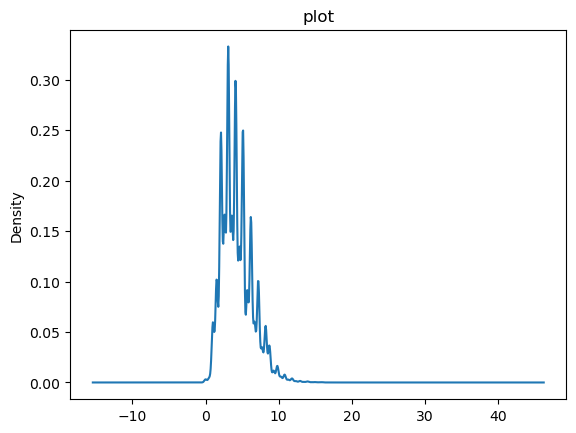

In [585]:
temp_df[focus_feature].plot(
    kind='kde', title='plot'
)

In [586]:
temp_df.loc[temp_df[focus_feature].isna()]

,temp,rain_3h,wind_speed,visibility,pressure,humidity,feels_like,Hour,Day,Month,Year,Day_of_Week,Day_of_Year
Time,,,,,,,,,,,,,


<Axes: xlabel='wind_speed', ylabel='visibility'>

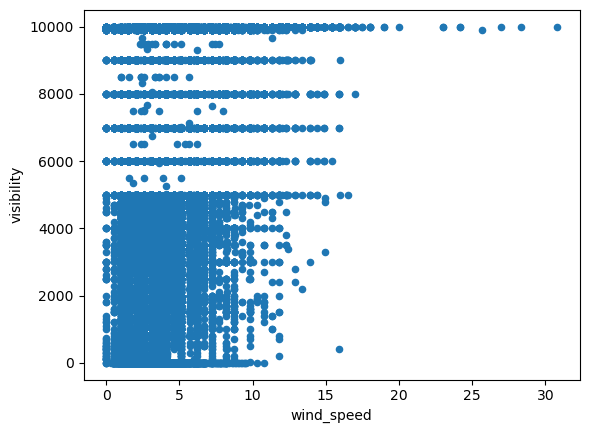

In [587]:
temp_df.plot(
    kind='scatter', 
    x = focus_feature,
    y = focus_feature_1
)

<Axes: >

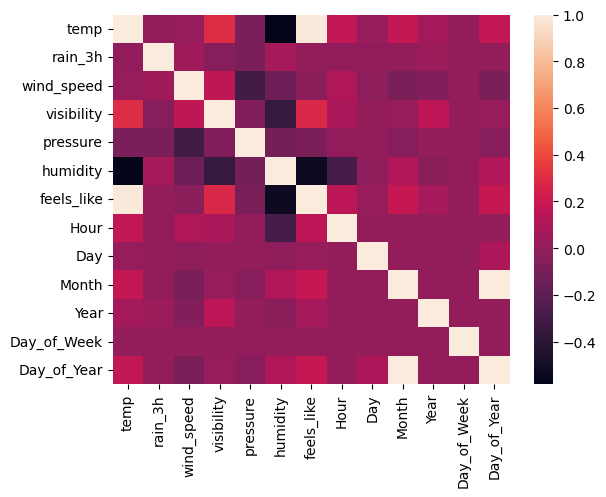

In [588]:
sns.heatmap(temp_df.corr(), annot=False)

<Axes: xlabel='Hour', ylabel='wind_speed'>

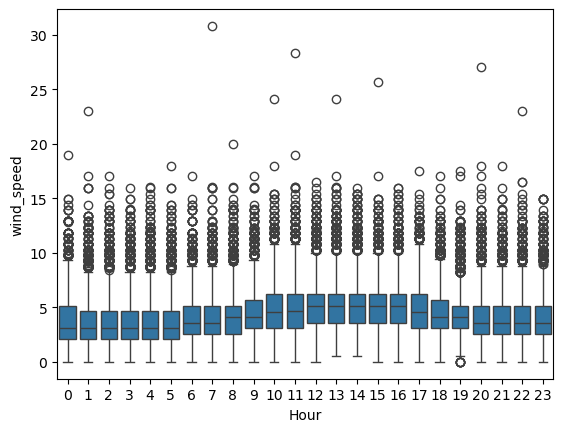

In [589]:
sns.boxplot(data=temp_df, x='Hour', y=focus_feature)

<Axes: xlabel='Day_of_Week', ylabel='wind_speed'>

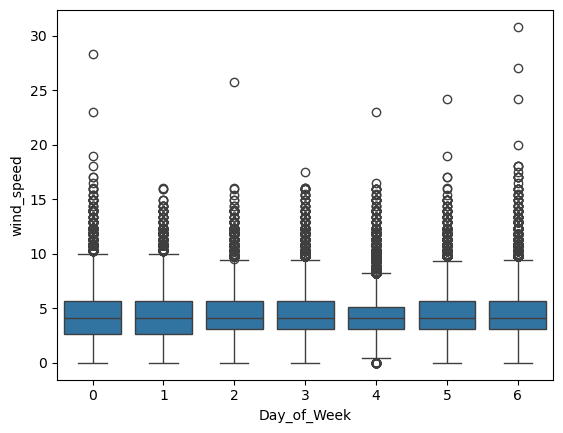

In [590]:
sns.boxplot(data=temp_df, x='Day_of_Week', y=focus_feature)

#### 3. Modeling Approach
- Linear Regression Model
    - Used to forecast future power prices based on the engineered features.
- Fourier Analysis for Seasonality
    - Seasonal components are extracted using Fourier series to capture recurring patterns
- Lag Features for Cyclicality
    - Historical price data is used to generate lagged features that capture temporal dependencies and recurring trends, as indicated by autocorrelation analysis.
- Cross-Validation (Cross-Val):
    - The model is trained using K-Fold Cross-Validation to assess its performance across different data subsets, ensuring it generalizes well to unseen data

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

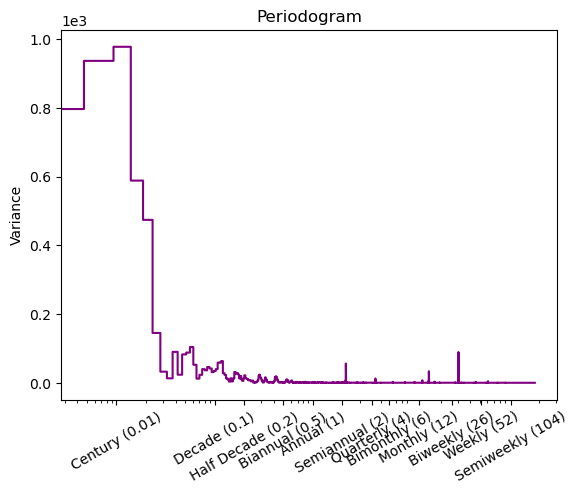

In [592]:
#Periodogram for fourier analysis
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([0.01, 0.1, 0.2, 0.5, 1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Century (0.01)",
            "Decade (0.1)",
            "Half Decade (0.2)",
            "Biannual (0.5)",
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax
plot_periodogram(Y_Train)

In [593]:
def add_fourier_features(df):
    fourier = CalendarFourier(freq="A", order=10)  # 6 sin/cos pairs for "M"onthly seasonality
    
    dp = DeterministicProcess(
        index=df.index,
        constant=True,               # dummy feature for bias (y-intercept)
        order=1,                     # trend (order 1 means linear)
        seasonal=True,               # weekly seasonality (indicators)
        additional_terms=[fourier],  # annual seasonality (fourier)
        drop=True,                   # drop terms to avoid collinearity
    )
    
    Season = dp.in_sample()  # create features for dates in tunnel.index
    df = pd.concat([Season, df], axis=1)
    return df
df = add_fourier_features(df)

C:\Users\ddoko\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:569: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


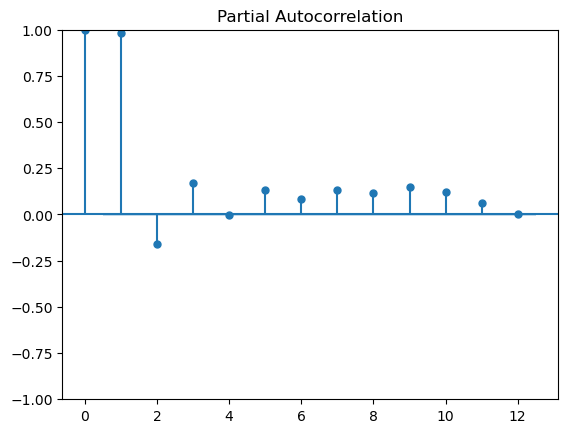

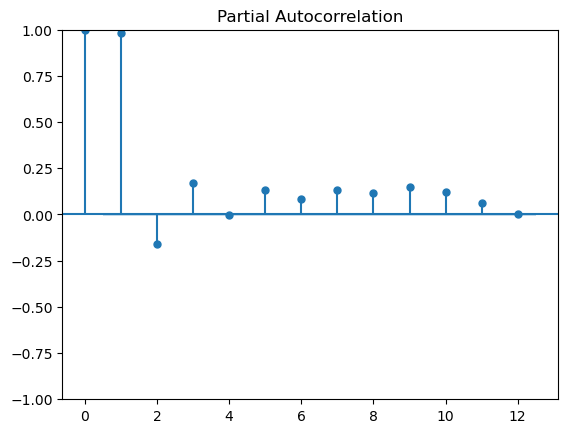

In [594]:
plot_pacf(df['Price (EUR/MWhe)'], lags=12)

In [595]:
def add_lags(df):
    target_map = price_df['Price (EUR/MWhe)'].to_dict()
    lag1 = (df.index - pd.Timedelta('1 day')).map(target_map)
    lag2 = (df.index - pd.Timedelta('2 days')).map(target_map)
    lag3 = (df.index - pd.Timedelta('3 days')).map(target_map)
    df.insert(0, "lag1", lag1, True)
    df.insert(1, "lag2", lag2, True)
    df.insert(2, "lag3", lag3, True)    
    return df
df = add_lags(df)
df = df.fillna(0.0)

In [596]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    FEATURES = df.columns[:-1]
    TARGET = 'Price (EUR/MWhe)'
    X = df[FEATURES]
    Y = df[TARGET]

    # train = df.loc[df.index < '01-01-2021']
    # test = df.loc[df.index >= '01-01-2021']
    
    X_Train = train[FEATURES]
    Y_Train = train[TARGET]
    
    X_Test = test[FEATURES]
    Y_Test = test[TARGET]
    
    model = LinearRegression()
    model.fit(X_Train, Y_Train)
    Y_pred = model.predict(X_Test)
    preds.append(Y_pred)
    score = np.sqrt(mean_squared_error(Y_Test, Y_pred))
    scores.append(score)
    # Y_pred = pd.Series(model.predict(X_Test), index=X_Test.index)


In [597]:
# train = df.loc[df.index < '01-01-2021']
val_test = df.loc[df.index >= '01-01-2021']

FEATURES = FEATURES = df.columns[:-1]
TARGET = 'Price (EUR/MWhe)'

X_val_test = val_test[FEATURES]
Y_val_test = val_test[TARGET]
# reg.fit(X_val_test, Y_val_test)

Y_pred = pd.Series(model.predict(X_val_test), index=X_val_test.index)

<function matplotlib.pyplot.show(close=None, block=None)>

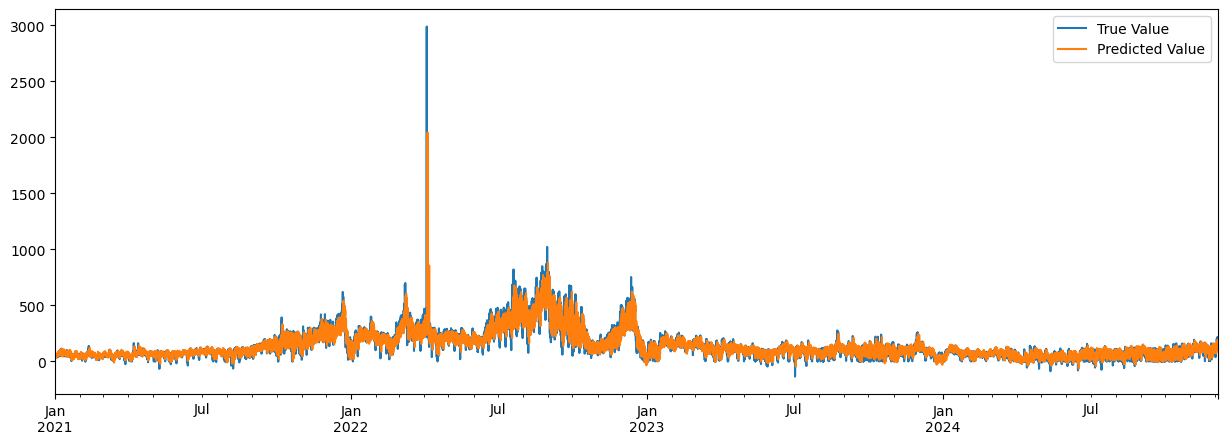

In [598]:
fig, ax = plt.subplots(figsize=(15, 5))
Y_val_test.plot(ax=ax, label = 'True Value')
Y_pred.plot(ax=ax, label = 'Predicted Value')
ax.legend(['True Value', 'Predicted Value'])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

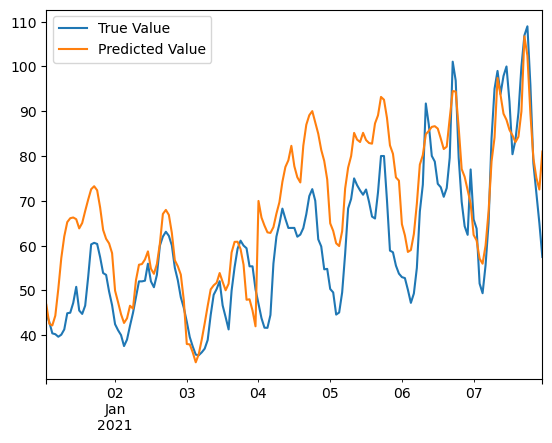

In [599]:
ax = Y_val_test.loc[(Y_val_test.index > '01-01-2021')&(Y_val_test.index < '01-08-2021')].plot()
Y_pred.loc[(Y_pred.index > '01-01-2021')&(Y_pred.index < '01-08-2021')].plot()
ax.legend(['True Value', 'Predicted Value'])
plt.show

In [600]:
score = np.sqrt(mean_squared_error(Y_val_test, Y_pred))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 45.05


In [601]:
dump(model, 'model4.joblib') 

['model4.joblib']

### Predicting future prices

- Get current weather forecast from OpenWeather API
- Engineer lag and temporal feature to match training dataframe
- Run model to predict future prices
- Load in price curve from Entsoe API

In [603]:
lat = 48.857548
lon = 2.351377
API_key = r"08aaef8862165384f3748755a2a0dd9b"
count = 24 - (datetime.datetime.now().hour)
url = f"https://api.openweathermap.org/data/2.5/forecast?lat={lat}&lon={lon}&appid={API_key}&cnt={count}"

response = requests.get(url)
if response.status_code == 200:
    current_temp = response.json()  # Parse the JSON response
else:
    print(f"Error: {response.status_code}")

delta = 2
current_time = pd.Timestamp.now() 
start_time = "2015-01-01 00:00:00"
end_time = current_time + pd.Timedelta(f'{delta} days')
day_index = pd.date_range(start=start_time, end= end_time, freq='h')



In [604]:
base_current_df = pd.DataFrame(columns=base_temp_df.columns, index=day_index)
current_df = base_current_df.copy()
current_df = create_time_features(current_df)
current_df = add_fourier_features(current_df)

current_df = current_df.loc[current_df.index.strftime('%Y-%m-%d') == pd.Timestamp.now().strftime('%Y-%m-%d')]
current_df = current_df.loc[current_df.index.strftime('%Y-%m-%d') == pd.Timestamp.now().strftime('%Y-%m-%d')]

def add_lags(df):
    target_map = price_df['Price (EUR/MWhe)'].to_dict()
    lag1 = (df.index - pd.Timedelta('364 days')).map(target_map)
    lag2 = (df.index - pd.Timedelta('728 days')).map(target_map)
    lag3 = (df.index - pd.Timedelta('1092 days')).map(target_map)
    df.insert(0, "lag1", lag1, True)
    df.insert(1, "lag2", lag2, True)
    df.insert(2, "lag3", lag3, True)    
    return df
current_df = add_lags(current_df)

time = current_temp['list'][0]['dt']
time_txt = current_temp['list'][0]['dt_txt']
timestampp = pd.to_datetime(time_txt).strftime('%Y-%m-%d %H:%M')

C:\Users\ddoko\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:569: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


In [605]:
for x in range(0, len(current_temp['list'])):
    time_txt = current_temp['list'][x]['dt_txt']
    timestampp = pd.to_datetime(time_txt).strftime('%Y-%m-%d %H:%M')
    rain = current_temp['list'][x].get('rain', {}).get('3h', 0)  # Default to 0 if 'rain' or '3h' is missing
    visibility = current_temp['list'][x].get('visibility', {})  # Default to 0 if 'rain' or '3h' is missing

    current_df.loc[timestampp, base_temp_df.columns] = [
        current_temp['list'][x]['main']['temp'],
        rain, 
        current_temp['list'][x]['wind']['speed'],
        visibility,
        # current_temp['list'][x]['visibility'],  
        current_temp['list'][x]['main']['pressure'],
        current_temp['list'][x]['main']['humidity'],
        current_temp['list'][x]['main']['feels_like']
    ]

current_df = current_df.loc[(current_df.index.day == pd.Timestamp.now().day)&\
(current_df.index.hour >= pd.Timestamp.now().hour)]

numeric_columns = ['temp', 'rain_3h', 'wind_speed', 'visibility', 'pressure', 'humidity', 'feels_like']
for col in numeric_columns:
    current_df[col] = pd.to_numeric(current_df[col], errors='coerce')
current_df = current_df.interpolate(method='time', limit_direction='both', axis=0)

model = load('model4.joblib')

In [606]:
X_forecast = current_df
# Y_val_test = val_test[TARGET]
# reg.fit(X_val_test, Y_val_test)

Y_pred = pd.Series(model.predict(X_forecast), index=X_forecast.index)

In [607]:
start = datetime.datetime.now().strftime('%Y%m%d%H%M')
end = datetime.datetime.now().strftime('%Y%m%d') + '2359'
out_domain = in_domain = r"10YFR-RTE------C"
security_token = r"12b06457-bd0a-415f-b433-865595cf1ee3"

url = f"https://web-api.tp.entsoe.eu/api?documentType=A44&periodStart={start}&periodEnd={end}&out_Domain={out_domain}&in_Domain={in_domain}&securityToken={security_token}"

response = requests.get(url)

if response.status_code == 200:
    root = ET.fromstring(response.text)
    
    # Define namespace
    namespace = {'ns': 'urn:iec62325.351:tc57wg16:451-3:publicationdocument:7:3'}
    
    # Initialize an empty list to store data
    data = []
    
    # Iterate through TimeSeries elements
    for timeseries in root.findall('ns:TimeSeries', namespace):
        period = timeseries.find('ns:Period', namespace)
        time_interval = period.find('ns:timeInterval', namespace)
        start_time = time_interval.find('ns:start', namespace).text
        
        # Iterate through Point elements
        for point in period.findall('ns:Point', namespace):
            position = int(point.find('ns:position', namespace).text)
            price = float(point.find('ns:price.amount', namespace).text)
            timestamp = pd.Timestamp(start_time) + pd.Timedelta(hours=position - 1)
            data.append({'timestamp': timestamp, 'price': price})
    
    # Create a DataFrame
    power_curve_df = pd.DataFrame(data)
    power_curve_df = power_curve_df.set_index('timestamp')
    power_curve_df.index = pd.to_datetime(power_curve_df.index.strftime("%Y-%m-%d %H:%M:%S"))
    
else:
    print(f"Error: {response.status_code}")

price_curve = power_curve_df.loc[(power_curve_df.index.day == pd.Timestamp.now().day)&\
(power_curve_df.index.hour >= pd.Timestamp.now().hour)]

In [608]:
price_curve = power_curve_df.loc[(power_curve_df.index.day == pd.Timestamp.now().day)&\
(power_curve_df.index.hour >= pd.Timestamp.now().hour)]

<function matplotlib.pyplot.show(close=None, block=None)>

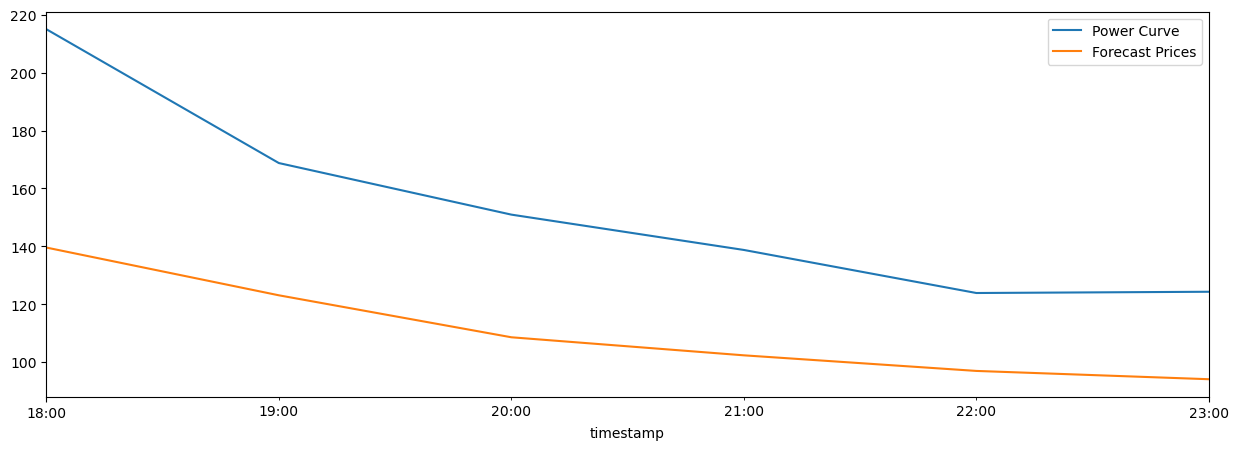

In [609]:
fig, ax = plt.subplots(figsize=(15, 5))
price_curve.plot(ax=ax, label = 'Power Curve')
Y_pred.plot(ax=ax, label = 'Forecast Prices')
ax.legend(['Power Curve', 'Forecast Prices'])
plt.show

### Trading Strategy
- Comparison of predicted prices against actual market prices.
- Identification of profitable trading windows by analyzing time spreads.

- Trading Strategy Logic
    - Short the Spread: When the market overvalues the spread (market prices exceed model predictions).
    - Long the Spread: When the market undervalues the spread (market prices fall below model predictions).

In [611]:
isinstance(price_curve, pd.DataFrame)

True

<function matplotlib.pyplot.show(close=None, block=None)>

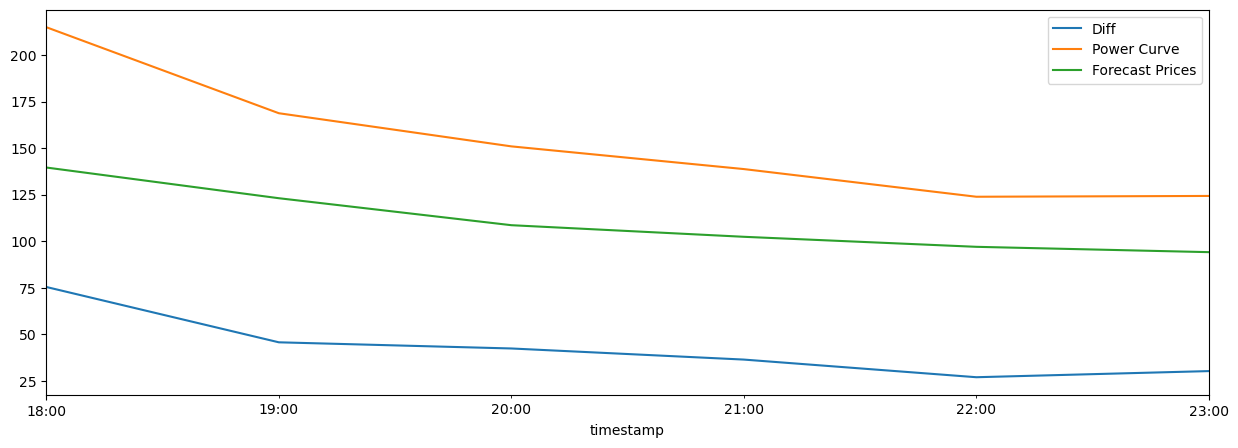

In [612]:
diff = price_curve['price'] - Y_pred
fig, ax = plt.subplots(figsize=(15, 5))
diff.plot(ax=ax, label = 'Diff')
price_curve.plot(ax=ax, label = 'Power Curve')
Y_pred.plot(ax=ax, label = 'Forecast Prices')
ax.legend(['Diff','Power Curve', 'Forecast Prices'])
plt.show

In [613]:
profit = diff[diff.idxmin()]-diff[diff.idxmax()]
profit

-48.49009737968444

In [614]:
print(f"{diff.idxmin()} at price {diff[diff.idxmin()]}")

2025-01-15 22:00:00 at price 26.911193752288824


In [615]:
print(f"{diff.idxmax()} at price {diff[diff.idxmax()]}")

2025-01-15 18:00:00 at price 75.40129113197327
